In [1]:
# !python -m spacy download ru_core_news_lg

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
from sklearn.model_selection import GroupKFold

import pytorch_lightning as pl

import utils

%load_ext autoreload
%autoreload 1
%aimport utils

In [3]:
data_folder = '../data/'

In [4]:
df = utils.read_preprocessed_financial_data(data_folder, enc_cols=['mcc_description', 'tr_description'])
df.shape 

(3751083, 10)

In [5]:
df.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description,tr_description,week
0,39026145.0,0,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",0
1,39026145.0,13328582400,4814.0,1030,-5614.79,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",0
2,39026145.0,17673984000,4814.0,1030,-1122.96,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1
3,39026145.0,30168547200,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1
4,39026145.0,48592051200,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1


In [6]:
clients = df['customer_id'].unique()
clients = clients[:100] # drop this row (I just tested the code with small amount of data)

df_week = []

for client_id in tqdm(clients):
    client_data = df[df['customer_id'] == client_id]
    client_weeks = client_data.week.unique()
    
    for week in client_weeks:
        client_data_week = client_data[client_data['week'] == week]
        df_week.append(
            {
                'transactions': client_data_week['mcc_code'].tolist(),
                'amounts': client_data_week['amount'].tolist(),
                'tr_datetime': client_data_week['tr_datetime'].tolist(),
                'tr_type': client_data_week['tr_type'].tolist(),
                'mcc_description': client_data_week['mcc_description'].tolist(), # add mcc_description embeddings
                'tr_description': client_data_week['tr_description'].tolist(), # add tr_description embeddings
                'term_id': client_data_week['term_id'].tolist(),
                'customer_id': client_id, 
                'week': week,
                'gender': client_data_week['gender'].tolist()
            }
        )

100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


In [7]:
df_week = pd.DataFrame(df_week)
df_week.shape

(5990, 10)

In [8]:
df_week.head(3)

,transactions,amounts,tr_datetime,tr_type,mcc_description,tr_description,term_id,customer_id,week,gender
0,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5499....","[-2245.92, -5614.79, -1392.47, -920.83, -1010....","[0, 13328582400, 3317241600, 9680601600, 14449...","[1030, 1030, 1010, 1010, 1010, 1010, 1010, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[4814.0, 4814.0, 4814.0, 4814.0, 4814.0, 5499....","[-1122.96, -2245.92, -2245.92, -2245.92, -2245...","[17673984000, 30168547200, 48592051200, 487840...","[1030, 1030, 1030, 1030, 1030, 1010, 1010, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"[4814.0, 4814.0, 4814.0, 5331.0, 5331.0, 5331....","[-2245.92, -449.18, -1122.96, -6288.56, -1122....","[42837984000, 79248240000, 79340169600, 0, 0, ...","[1030, 1030, 1030, 1110, 1110, 1110, 1110, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [9]:
MIN_LEN = 20
MAX_LEN = 50

lens = df_week.transactions.apply(lambda x: len(x))
df_week = df_week[(lens >= MIN_LEN) & (lens <= MAX_LEN)]
df_week.shape

(598, 10)

In [10]:
features = ['transactions', 'amounts', 'tr_datetime', 'tr_type', 'term_id', 'mcc_description', 'tr_description'] 
desc_cols = ['mcc_description', 'tr_description']

INPUT_SIZE = len(list(set(features) - set(desc_cols)))
if 'mcc_description' in features:
    INPUT_SIZE += len(df['mcc_description'].iloc[0])
if 'tr_description' in features:
    INPUT_SIZE += len(df['tr_description'].iloc[0])
    
EPOCHS = 10
N_SPLITS = 5

In [11]:
INPUT_SIZE

605

# GRU

In [12]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="GRU"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.01%       3.816ms         0.02%       9.627ms      90.821us       0.000us         0.00%      33.000us       0.311us         372 b           0 b       1.32 Mb           0 

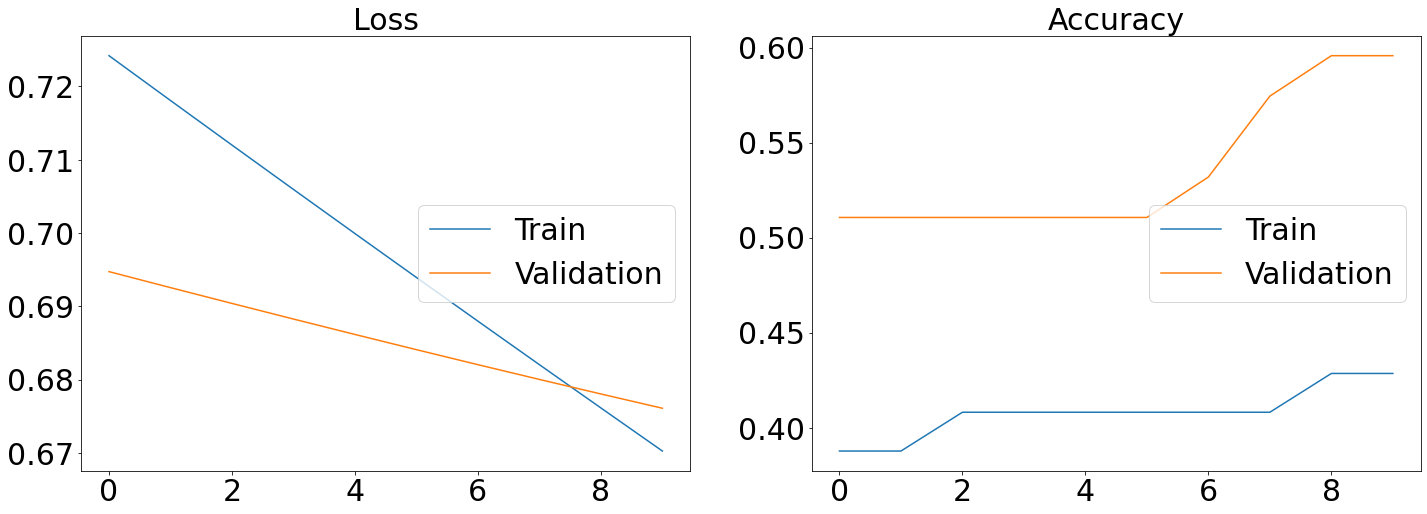

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.02%     244.000us         0.25%       3.116ms     779.000us       3.14 Kb           0 b             4  
                                            aten::empty         0.48%       5.907ms         0.48%       5.907ms      15.710us      15.68 Mb      15.68 Mb           376  
                                            aten::zero_         0.00%      16.000us         0.00%      16.000us       4.000us           0 b           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.03%       6.923ms         0.09%      21.960ms     207.170us       0.000us         0.00%      32.000us       0.302us         372 b           0 b       1.32 Mb           0 

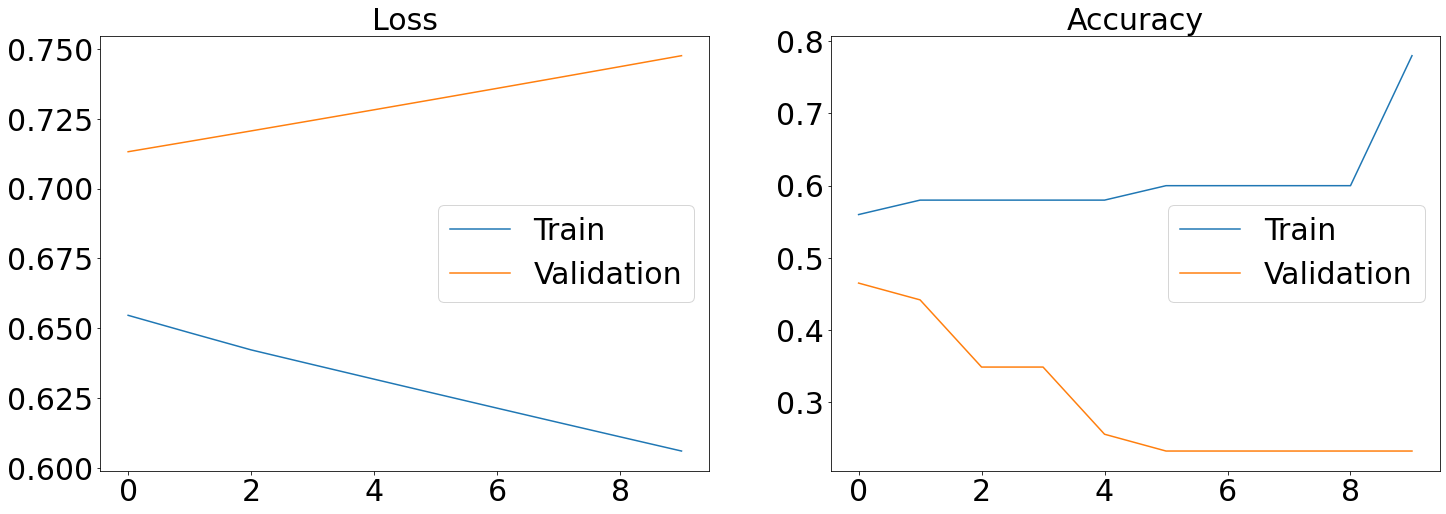

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.45%       4.768ms         0.55%       5.895ms       1.474ms       3.07 Kb           0 b             4  
                                            aten::empty         0.55%       5.806ms         0.55%       5.806ms      15.441us      15.37 Mb      15.37 Mb           376  
                                            aten::zero_         0.00%      15.000us         0.00%      15.000us       3.750us           0 b           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.02%       5.966ms         0.09%      21.345ms     201.368us       0.000us         0.00%      32.000us       0.302us         372 b           0 b       1.32 Mb           0 

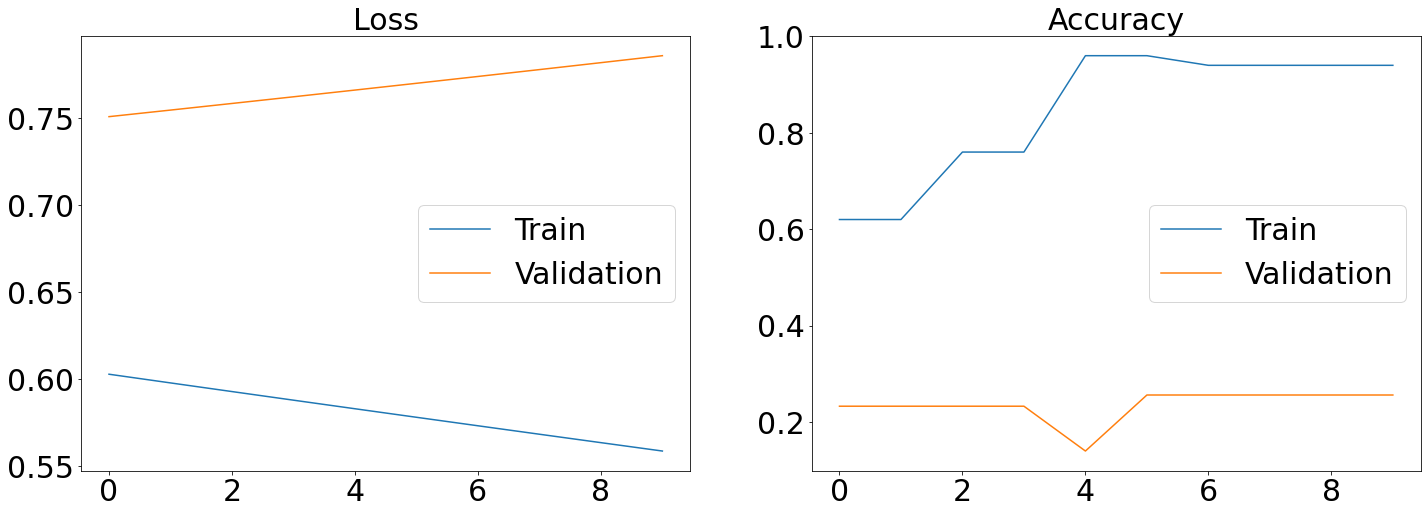

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.11%       1.257ms         0.21%       2.401ms     600.250us       2.95 Kb           0 b             4  
                                            aten::empty         0.29%       3.391ms         0.29%       3.391ms       9.019us      14.74 Mb      14.74 Mb           376  
                                            aten::zero_         0.00%      16.000us         0.00%      16.000us       4.000us           0 b           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.03%       7.611ms         0.11%      25.377ms     239.406us       0.000us         0.00%      32.000us       0.302us         372 b           0 b       1.32 Mb           0 

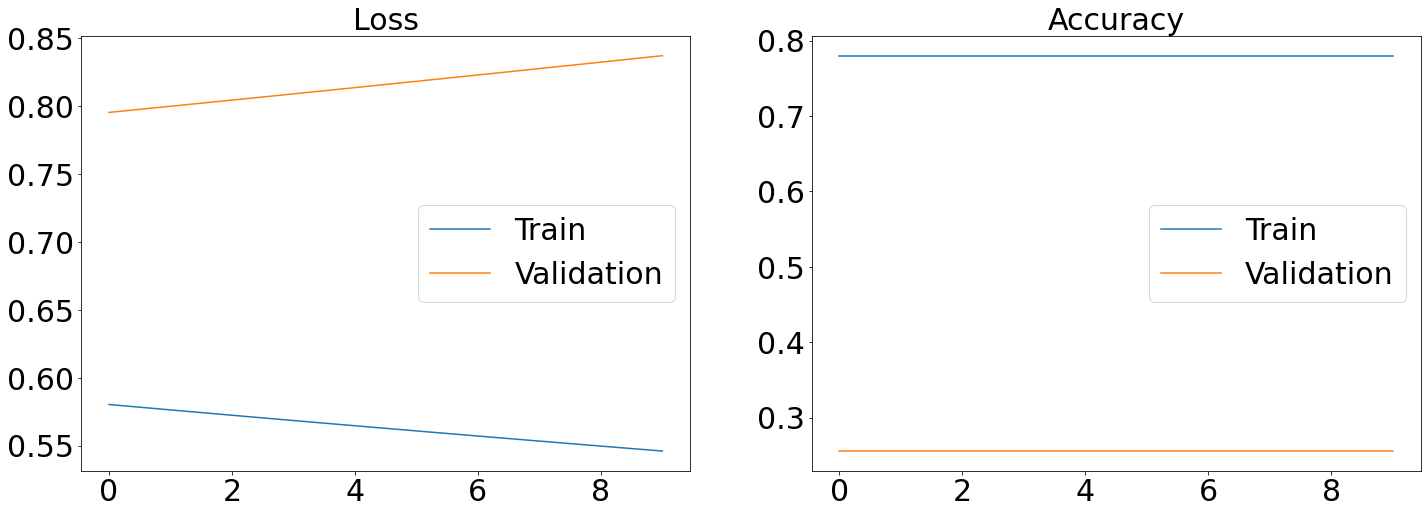

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.02%     257.000us         0.13%       1.480ms     370.000us       2.64 Kb           0 b             4  
                                            aten::empty         0.38%       4.430ms         0.38%       4.430ms      11.877us      13.06 Mb      13.06 Mb           373  
                                            aten::zero_         0.00%      13.000us         0.00%      13.000us       3.250us           0 b           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.04%       9.070ms         0.10%      24.458ms     230.736us       0.000us         0.00%      52.000us       0.491us         372 b           0 b       1.32 Mb           0 

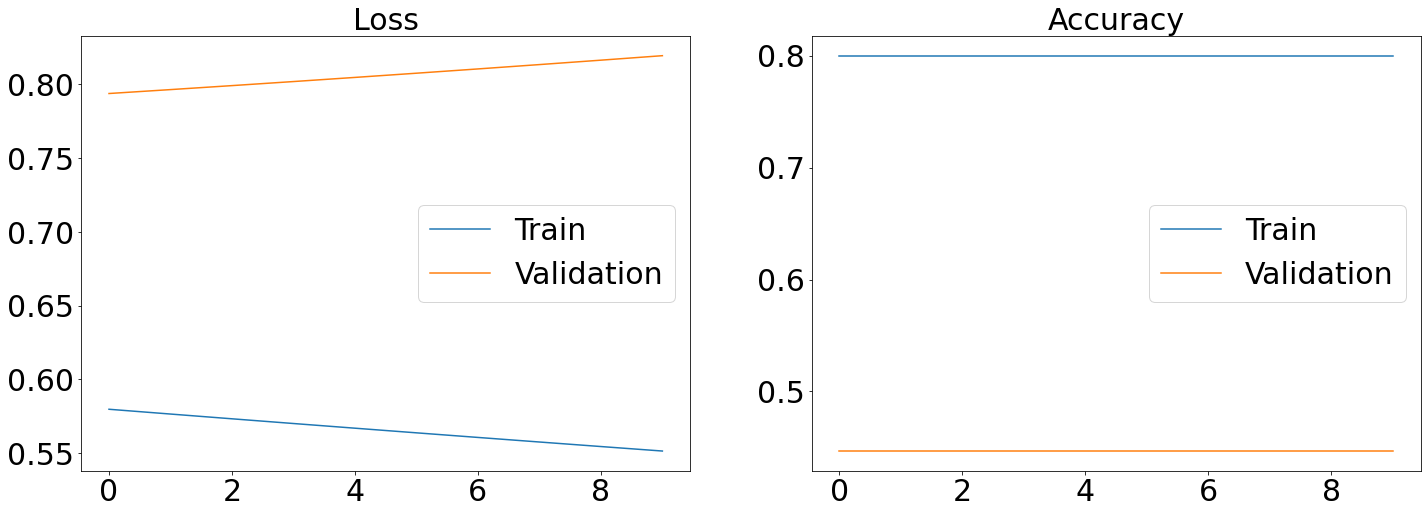

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::zeros         0.02%     176.000us         0.03%     302.000us      75.500us       2.89 Kb           0 b             4  
                                            aten::empty         0.18%       1.971ms         0.18%       1.971ms       5.284us      14.31 Mb      14.31 Mb           373  
                                            aten::zero_         0.00%       9.000us         0.00%       9.000us       2.250us           0 b           

{'Accuracy': [0.6,
  0.9183673469387755,
  0.851063829787234,
  0.7380952380952381,
  0.2826086956521739],
 'ROC AUC': [0.1491228070175439,
  0.9183673469387755,
  0.15447154471544716,
  0.7712609970674487,
  0.3368298368298368],
 'PR AUC': [0.17705517972772772,
  1.0,
  0.8118817488874707,
  0.9225630315103998,
  0.39211329959317437]}

In [13]:
metrics_gru = utils.cross_validation(df_week, "GRU", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS)
metrics_gru

In [14]:
for metric_name, metric_val in metrics_gru.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))

Accuracy: 0.6780270220946842 ± 0.2252808328285569
ROC AUC: 0.46601050651381043 ± 0.31998954898337917
PR AUC: 0.6607226519437546 ± 0.32018862681693194


In [15]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="GRU"
)

# LSTM

In [16]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="LSTM"
)

In [ ]:
metrics_lstm = utils.cross_validation(df_week, "LSTM", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS)
metrics_lstm

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 39.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
39.9 K    Trainable params
0         Non-trainable params
39.9 K    Total params
0.160     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
for metric_name, metric_val in metrics_lstm.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))

# RNN

In [ ]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="RNN"
)

In [ ]:
metrics_rnn = utils.cross_validation(df_week, "RNN", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS)
metrics_rnn

In [ ]:
for metric_name, metric_val in metrics_rnn.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))